# Exercise 3. Multi-class Classification and Neural Networks

*Solution Author: Brian Pardo*

*These are solutions to [programming exercise 3](https://www.coursera.org/learn/machine-learning/programming/Y54Zu/multi-class-classification-and-neural-networks) for Coursera's Machine Learning course by Andrew Ng.*

In this exercise, we will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## Part 1. Multi-class Classification
For this exercise, we will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). In the first part of the exercise, we will extend our previous implemention of logistic regression and apply it to one-vs-all classification.

Let's start by loading the data and visualizing it.

In [1]:
import scipy.io
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
from numpy import matmul as mm

my_data = scipy.io.loadmat('ex3data1.mat')
# We now have X and y in memory.
x = my_data['X']
y = my_data['y']

# We also want to convert 10 to 0 since 0 is a valid index in python unlike MATLAB
y[y==10] = 0

(m, n) = np.shape(x)

In [2]:
# It is also helpful to have a function to append a column of 1's to x
def add_ones(x):
    ones = np.ones((len(x),1))
    return np.append(ones, x, axis=1)

In [3]:
def displayData(x):
    # m is number of samples, n is number of pixels
    (m, n) = np.shape(x)
    
    # number of rows/columns of pixels and images
    pad = 1
    l_pix = int(np.floor(np.sqrt(n)))
    l_img = int(np.ceil(np.sqrt(m)))
    w = l_pix*l_img+l_img*pad-1
    
    # initialize the grid
    img_grid = np.ones((w,w))
    
    for i, img in enumerate(x):
        # compute the start and end pixel for each image w/ pad
        h_start = (i%l_img)*l_pix+pad*(i%l_img)
        h_end = h_start+l_pix
        v_start = ((i)//l_img)*l_pix+pad*(i//l_img)
        v_end = v_start+l_pix
        
        # reshape image into square and replace image in grid
        image = img.reshape(l_pix, l_pix).T
        img_grid[v_start:v_end, h_start:h_end] = image
        
    return img_grid

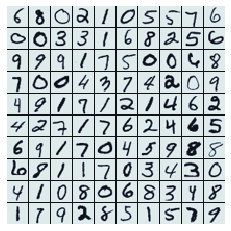

In [4]:
# Select a sample of the digits to display
sample = x[np.random.choice(m,100,replace=False)]

# We now display the images that have been
# reconstructed from the flat arrays
fig1, ax = plt.subplots(figsize=(4,4))
img_grid = displayData(sample)
ax.imshow(img_grid,cmap = 'bone_r')
ax.axis('off');

In [5]:
# We need the sigmoid function and cost function from the last exercise
def sigmoid(z):
    return np.power(1 + np.exp(-z), -1)

def cost_function(theta, x, y, lambda_r=0):
    m = len(x)
    theta = theta.reshape(-1,1)
    
    # Add ones column to x
    x = add_ones(x)
    
    # Regularized cost function
    cost = (1/m)*(-mm(y.T,np.log(sigmoid(mm(x,theta))))
               -mm((1-y).T,np.log(1-sigmoid(mm(x,theta)))))
    cost = cost+(lambda_r/(2*m))*np.sum(theta[1:,:]**2)
    
    # Regularized gradient
    grad = (1/m)*mm(x.T,sigmoid(mm(x,theta))-y).flatten()
    grad = grad + (lambda_r/m)*np.append([0],theta[1:,:])
    
    return float(cost), grad

In [6]:
# Let's check our cost function
theta_t = np.array([-2, -1, 1, 2]);
x_t = np.array(range(1,16,1)).reshape(3,5).T/10
y_t = (np.array([1,0,1,0,1]) >= 0.5).reshape(-1,1)
lambda_t = 3
J, grad = cost_function(theta_t, x_t, y_t, lambda_t);

print(f'Cost: {J:.5} | Expected cost: 2.534819');

Cost: 2.5348 | Expected cost: 2.534819


In [7]:
def one_vs_all(x, y, num_labels, lambda_r):
    """Returns array of optimized theta values
    x: training set pixels
    y: training set digit
    num_labels: number of digits in set
    lambda_r: regularization parameter
    """
    m = np.shape(x)[0];
    n = np.shape(x)[1];
    
    all_theta = np.zeros((num_labels, n+1))

    for k in range(num_labels):
        
        # set initial theta
        initial_theta = np.random.rand(n+1,)/100
        
        optim = minimize(cost_function, initial_theta, (x, (y == k).reshape(-1,1), lambda_r), 
                         jac=True, method='TNC', options={'maxiter': 100})
        
        all_theta[k,:] = optim.x
        
    return all_theta

In [8]:
def predict_digit(x, theta, num_labels):
    m = np.shape(x)[0];
    n = np.shape(x)[1];
    
    predicted_digit = np.zeros((m,))
    
    # add ones to x
    x = add_ones(x)
    
    prediction_array = mm(x,theta.T)
    predicted_digit = np.argmax(prediction_array,axis=1)
    
    return predicted_digit

In [9]:
all_theta = one_vs_all(x, y, 10, 0.1)

predictions = predict_digit(x, all_theta, 10)

Our model predicted 1. The actual digit is 1


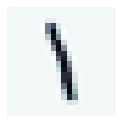

In [10]:
# We now display the images that have been
# reconstructed from the flat arrays
idx = np.random.choice(m,1)
digit_image = x[idx]
digit_truth = int(y[idx])
digit_prediction = int(predictions[idx])
print(f'Our model predicted {digit_prediction}. The actual digit is {digit_truth}')
fig2, ax = plt.subplots(figsize=(2,2))
img_grid = displayData(digit_image)
ax.imshow(img_grid,cmap = 'bone_r')
ax.axis('off');

In [11]:
#The accuracy of the model is
p = np.mean(predictions==y.T)*100
print(f'The accuracy of our model on the training set is {p:.1f}%.')

The accuracy of our model on the training set is 96.4%.


## Part 2. Neural Networks

In the previous part, we implemented multi-class logistic regression to recognize handwritten digits. However, logistic regression cannot form more complex hypotheses as it is only a linear classifier. (We could add more features such as polynomial features to logistic regression, but that can be very expensive to train.) In this part, we will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. 

For now, we will be using parameters from a neural network that has already been trained. Our goal is to implement the feedforward propagation algorithm to use these weights for prediction. In the next exercise, we will write the backpropagation algorithm for learning the neural network parameters.

In [12]:
my_weights = scipy.io.loadmat('ex3weights.mat')

theta1 = my_weights['Theta1']
theta2 = my_weights['Theta2']

theta = (theta1, theta2)

In [13]:
# We now implement the feedforward algorithm
def feed_forward(x, theta):
    """Return predictions for a neural network with known weights"""
    a = x
    
    for layer in theta:
        # add ones column
        a = add_ones(a)
        a = sigmoid(mm(a,layer.T))
    
    # predictions are shifted: python is 0-indexed and matlab is 1-indexed
    raw_predict = np.argmax(a,axis=1)
    
    # cycle predictions to account for this
    return (raw_predict+1)%10

nn_predictions = feed_forward(x,theta)

In [14]:
#The accuracy of the model is
p_nn = np.mean(nn_predictions==y.T)*100
print(f'The accuracy of the neural network on the training set is {p_nn:.1f}%.')

The accuracy of the neural network on the training set is 97.5%.


Our neural network predicted 4. The actual digit is 4


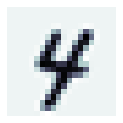

In [15]:
# We now display the images that have been
# reconstructed from the flat arrays
idx = np.random.choice(m,1)
digit_image = x[idx]
digit_truth = int(y[idx])
digit_prediction = int(nn_predictions[idx])
print(f'Our neural network predicted {digit_prediction}. The actual digit is {digit_truth}')
fig3, ax = plt.subplots(figsize=(2,2))
img_grid = displayData(digit_image)
ax.imshow(img_grid,cmap = 'bone_r')
ax.axis('off');

LR: 3
Neural net: 8
Truth: 8 


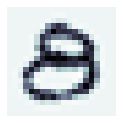

In [16]:
model_diffs = (x[nn_predictions!=predictions])
nn_diffs = (nn_predictions[nn_predictions!=predictions])
lr_diffs = (predictions[nn_predictions!=predictions])
true_diffs = (y[nn_predictions!=predictions])
diff_idx = np.random.choice(len(model_diffs),1,replace=False)

# We now display the images were classified
# differently between the two models
fig4, ax = plt.subplots(figsize=(2,2))
img_grid = displayData(model_diffs[diff_idx])
ax.imshow(img_grid,cmap = 'bone_r')
ax.axis('off')

print(f'LR: {int(lr_diffs[diff_idx])}\nNeural net: {int(nn_diffs[diff_idx])}\nTruth: {int(true_diffs[diff_idx])} ')